In [69]:
from pathlib import Path

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import os
from tqdm import tqdm
import numpy as np

import torchvision.transforms as v1
from torchvision.io import read_image

plt.rcParams["savefig.bbox"] = 'tight'
torch.manual_seed(1)

In [70]:
!pip install mlconfig

In [71]:
import torch, torchvision
from torch.utils.data.dataloader import DataLoader
from sklearn.model_selection import train_test_split

import os, shutil
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import mlconfig
from importlib import import_module
from torch.utils.data import Dataset, DataLoader
import pandas as pd

def load_function(attr):
    module_, func = attr.rsplit('.', maxsplit=1)
    return getattr(import_module(module_), func)

config = mlconfig.load('config_resnet18.yaml')

In [72]:
class MyDataset(Dataset):
    def __init__(self, root_dir, csv_file):
        s=[]
        with open(csv_file, 'r') as f:
            for i in f.readlines():
                s.append(i[:len(i)-1])
        self.sig_filenames = s
        self.root_dir = root_dir
        #csv = pd.read_csv(csv_file)
        #self.sig_filenames = csv["fragment_name"].values
        #self.sig_labels = csv["label"].values
        #self.root_dir = root_dir

    def __len__(self):
        return len(self.sig_filenames)

    def __getitem__(self, idx):
        #with open(self.root_dir + '/' + self.sig_filenames[idx] + '.npy', 'r+') as fl:
         # data_file = np.frombuffer(fl.read(), dtype=np.float32)
        '''data_file = np.asarray(np.load(self.root_dir + '/' + self.sig_filenames[idx] + '.npy', 'r+'), dtype=np.float32)
        if 'drone' in list(self.sig_filenames[idx].split('_')):
            label = torch.tensor(0)
        if 'noise' in list(self.sig_filenames[idx].split('_')):
            label = torch.tensor(1)
        if 'wifi' in list(self.sig_filenames[idx].split('_')):
            label = torch.tensor(2)
        return data_file, label'''

        data_file = np.asarray(np.load(self.sig_filenames[idx][:5]+'_pic'+self.sig_filenames[idx][5:], 'r+'), dtype=np.float32)
        if 'drone' in list(self.sig_filenames[idx].split('_')):
            label = torch.tensor(0)
        if 'noise' in list(self.sig_filenames[idx].split('_')):
            label = torch.tensor(1)
        if 'wifi' in list(self.sig_filenames[idx].split('_')):
            label = torch.tensor(2)
        return data_file, label

In [73]:
dataset = MyDataset(root_dir='calib_pic', csv_file='calib/dataset.txt')
train_set, valid_set = torch.utils.data.random_split(dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(42))
batch_size = config.batch_size
train_dataloader = torch.utils.data.DataLoader(
  train_set,
  batch_size=batch_size,
  shuffle=True,
  drop_last=True)
valid_dataloader = torch.utils.data.DataLoader(
  valid_set,
  batch_size=batch_size,
  drop_last=True,
  shuffle=True)

In [74]:
dataloaders = {}
dataloaders['train'] = train_dataloader
dataloaders['val'] = valid_dataloader
dataset_sizes = {}
dataset_sizes['train'] = len(train_set)
dataset_sizes['val'] = len(valid_set)

In [82]:
torch.cuda.empty_cache()
model = load_function(config.model.architecture)(pretrained=False)
lin = model.conv1
new_lin = nn.Sequential(
    nn.Conv2d(2, 3, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
    lin
)
model.conv1 = new_lin
model.fc = torch.nn.Linear(in_features=512, out_features=3, bias=True)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

import numpy as np
import copy, timeit

optimizer = load_function(config.optimizer.name)(model.parameters(), lr=config.optimizer.lr)
criterion = load_function(config.loss_function.name)()
scheduler = load_function(config.scheduler.name)(optimizer, step_size=config.scheduler.step_size, gamma=config.scheduler.gamma)

if device != 'cpu':
    model = model.to(device)

val_loss = []
val_acc = []
train_loss = []
train_acc = []
epochs = config.epoch

best_acc = 0
best_model = copy.deepcopy(model.state_dict())

start = timeit.default_timer()
for epoch in range(1, epochs+1):
    print(f"Epoch : {epoch}\n")
    dataloader = None

    for phase in ['train', 'val']:
        running_loss = 0.0
        running_corrects = 0

        for (img, label) in tqdm(dataloaders[phase]):
            #img = torch.unsqueeze(img,1)
            #label = torch.unsqueeze(label,1)
            img, label = img.to(device), label.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                output = model(img)
                #print(output)
                #pred = output.max(dim=1, keepdim=True)
                #pred = torch.squeeze(pred)
                _, pred = torch.max(output.data, 1)
                #print(output.shape)
                #print(output)
                #print(label.shape)
                #print(label)
                loss = criterion(output, label)
                #print(output)
                #print(label)
                #print(loss.item())
                #with torch.autocast('cuda'):
                 #   loss = criterion(output, label)
                if phase=='train' :
                    loss.backward()
                    optimizer.step()
            
            running_loss += loss.item() * img.size(0)
            running_corrects += torch.sum(pred == label.data)

        print(running_loss, dataset_sizes[phase], running_corrects)
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
                
        if phase=='train' :
            train_loss.append(epoch_loss)
            train_acc.append(epoch_acc)
        else :
            val_loss.append(epoch_loss)
            val_acc.append(epoch_acc)
            if val_acc[-1] > best_acc :
                best_acc = val_acc[-1]
                best_model = copy.deepcopy(model.state_dict())
    print()

end = timeit.default_timer()
print(f"Total time elapsed = {end - start} seconds")
name = 'resnet18_img_2.pt'
model.load_state_dict(best_model)
print(model)
model = model.to('cpu')
#model.fuse_model()     
model.qconfig = torch.quantization.get_default_qat_qconfig('qnnpack')   
print(model.qconfig)  
torch.quantization.prepare_qat(model, inplace=True)  
model.eval()  
torch.quantization.convert(model, inplace=True)  
input = torch.ones(1, 2, 640, 1280)  
traced_model = torch.jit.trace(model, input)  
torch.jit.save(traced_model, name)
print('done')

cuda:0
Epoch : 1



100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:33<00:00,  3.68it/s]


759.3535317089409 2005 tensor(1763, device='cuda:0')
train Loss: 0.3787 Acc: 0.8793


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  7.09it/s]


32.523051746189594 501 tensor(486, device='cuda:0')
val Loss: 0.0649 Acc: 0.9701

Epoch : 2



100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:33<00:00,  3.70it/s]


147.58058872399852 2005 tensor(1954, device='cuda:0')
train Loss: 0.0736 Acc: 0.9746


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  7.08it/s]


28.852444116026163 501 tensor(486, device='cuda:0')
val Loss: 0.0576 Acc: 0.9701

Epoch : 3



100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:33<00:00,  3.69it/s]


64.49854567687726 2005 tensor(1977, device='cuda:0')
train Loss: 0.0322 Acc: 0.9860


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  7.09it/s]


39.57184924837202 501 tensor(487, device='cuda:0')
val Loss: 0.0790 Acc: 0.9721

Epoch : 4



100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:33<00:00,  3.69it/s]


14.710067377978703 2005 tensor(1995, device='cuda:0')
train Loss: 0.0073 Acc: 0.9950


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  7.08it/s]


15.633978513273178 501 tensor(491, device='cuda:0')
val Loss: 0.0312 Acc: 0.9800

Epoch : 5



100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:33<00:00,  3.69it/s]


54.91093619413732 2005 tensor(1981, device='cuda:0')
train Loss: 0.0274 Acc: 0.9880


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  7.08it/s]


36.89784257300198 501 tensor(490, device='cuda:0')
val Loss: 0.0736 Acc: 0.9780

Total time elapsed = 191.46113369999966 seconds
QuantizableResNet(
  (conv1): Sequential(
    (0): Conv2d(2, 3, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): QuantizableBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (add_

In [83]:
'''model = model.to('cpu')
model.eval()
trace_model = torch.jit.trace(model, torch.Tensor(1,2,640,1280))
trace_model.save(name)
torch.save(model.state_dict(), name)'''

"model = model.to('cpu')\nmodel.eval()\ntrace_model = torch.jit.trace(model, torch.Tensor(1,2,640,1280))\ntrace_model.save(name)\ntorch.save(model.state_dict(), name)"

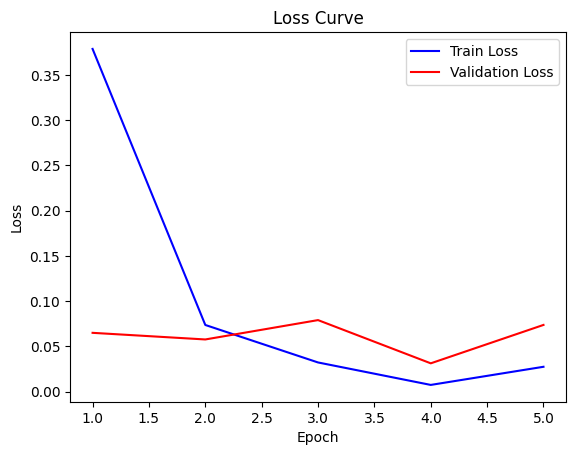

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

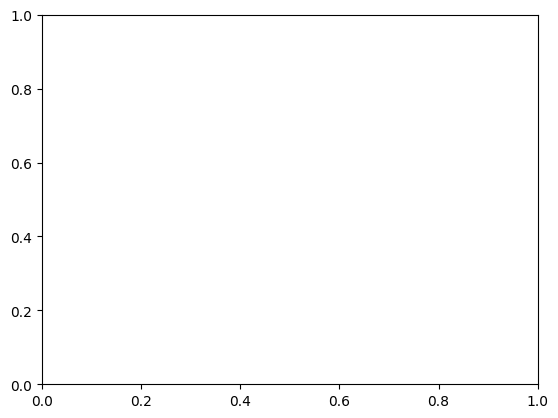

In [84]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1,epochs+1), train_loss, color='blue')
plt.plot(range(1,epochs+1), val_loss, color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend(['Train Loss', 'Validation Loss'])
plt.show()
plt.figure()
plt.plot(range(1,epochs+1), train_acc, color='blue')
plt.plot(range(1,epochs+1), val_acc, color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.show()